In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


#Read in raw data
schoolData = pd.read_csv('C:/Users/jkras/Desktop/All_Data_By_School_Final.csv',low_memory=False)
testScores = pd.read_csv('C:/Users/jkras/Desktop/1516testresults_masking_removed.csv', low_memory=False)
raceData = pd.read_csv('C:/Users/jkras/Desktop/Ec_Pupils_Expanded (2017 Race Compositions by School).csv',low_memory=False)



piv_test = pd.pivot_table(testScores, values='Percent GLP',index=['School Code'],columns='Subject')

piv_test.index.name = 'unit_code'

piv_test.columns = [str(col) + '_GLP' for col in piv_test.columns]

piv_alltest = piv_test.reset_index()

schoolData_alltest = schoolData.merge(piv_alltest,how='left',on='unit_code')



racecols = ['Indian Male', 'Indian Female', 'Asian Male',
       'Asian Female', 'Hispanic Male', 'Hispanic Female', 'Black Male',
       'Black Female', 'White Male', 'White Female', 'Pacific Island Male',
       'Pacific Island Female', 'Two or  More Male', 'Two or  More Female',
       'Total', 'White', 'Black', 'Hispanic', 'Indian', 'Asian',
       'Pacific Island', 'Two or More', 'White_Pct', 'Majority_Minority']

racecols_renamed = [str(col) + '_RACE' for col in racecols]

racecol_rename_dict = {i:j for i,j in zip(racecols,racecols_renamed)}

raceData.rename(index=str, columns=racecol_rename_dict,inplace=True)

raceData['unit_code'] = raceData['unit_code'].apply(str)

for i,j in raceData.iterrows():
    
    if len(raceData['unit_code'][i]) == 5:
        raceData.loc[i, 'unit_code'] = '0' + raceData['unit_code'][i]
        

schoolData_testRace = schoolData_alltest.merge(raceData,how='left',on='unit_code')




region_df = testScores[['School Code','SBE District']]

region_df.rename(index=str, columns={'School Code':'unit_code'},inplace=True)

region_df_unique = region_df.drop_duplicates()

schoolData_testRaceRegion = schoolData_testRace.merge(region_df_unique,how='left',on='unit_code')

schoolData_testRaceRegion.shape

C:\Users\jkras\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(2579, 352)

In [233]:
#expenditures variable list
exp_list = ['lea_total_expense_num','lea_salary_expense_pct','lea_benefits_expense_pct','lea_services_expense_pct',
'lea_supplies_expense_pct','lea_instruct_equip_exp_pct']

#teacher qualifications variable list
teach_list = ['flicensed_teach_pct', 'tchyrs_0thru3_pct', 'tchyrs_4thru10_pct', 'tchyrs_11plus_pct', 'class_teach_num', 'nbpts_num', 'advance_dgr_pct',
'_1yr_tchr_trnovr_pct', 'emer_prov_teach_pct', 'lateral_teach_pct', 'highqual_class_pct', 'lea_flicensed_teach_pct',
'lea_tchyrs_0thru3_pct', 'lea_tchyrs_4thru10_pct', 'lea_tchyrs_11plus_pct', 'lea_class_teach_num', 'lea_nbpts_num', 'lea_advance_dgr_pct',
'lea_1yr_tchr_trnovr_pct', 'lea_emer_prov_teach_pct', 'lea_lateral_teach_pct', 'lea_highqual_class_pct', 'lea_highqual_class_hp_pct',
'lea_highqual_class_lp_pct', 'lea_highqual_class_all_pct', 'lea_not_highqual_class_hp_pct', 'lea_not_highqual_class_lp_pct',
'lea_not_highqual_class_all_pct']

#performance scores list
grade_list = ['SPG Score', 'Reading  SPG Score', 'Math SPG Score', 'EVAAS Growth Score', 'Overall Achievement Score', 'Read Score', 'Math Score',
'Science Score', 'Math I Score', 'English II Score', 'Biology Score', 'The ACT Score', 'ACT WorkKeys Score', 'Math Course Rigor Score',
'Cohort Graduation Rate Standard Score']

In [234]:
#alias full data set, merged from 3 CSV files
all_df = schoolData_testRaceRegion

#cast SBE district to categorical to generate dummy indicators, dropping reference level, and concatenating to full data set (original SBE District feature will be dropped below)
all_df['SBE District'] = all_df['SBE District'].astype('category')
Coded_District = pd.get_dummies(all_df['SBE District'],drop_first=True)
all_df = pd.concat([all_df,Coded_District],axis=1)


#scale the SPG Score feature
all_df['SPG Score Scaled'] = all_df['SPG Score']*(.01)
pd.Series.to_frame(all_df['SPG Score Scaled']).shape

#mean impute missing scaled SPG Score on region-wise basis; where no regional data, mean impute across all regions
mean_filled = all_df.groupby('SBE District')['SPG Score Scaled'].transform('mean')
all_df['SPG Score Scaled'] = all_df['SPG Score Scaled'].fillna(mean_filled)

all_df['SPG Score Scaled'] = pd.Series.to_frame(all_df['SPG Score Scaled']).fillna(pd.Series.to_frame(all_df['SPG Score Scaled']).mean())

all_df.shape


#column names from Race data, used for subsetting below
racecols = ['Indian Male', 'Indian Female', 'Asian Male',
       'Asian Female', 'Hispanic Male', 'Hispanic Female', 'Black Male',
       'Black Female', 'White Male', 'White Female', 'Pacific Island Male',
       'Pacific Island Female', 'Two or  More Male', 'Two or  More Female',
       'Total', 'White', 'Black', 'Hispanic', 'Indian', 'Asian',
       'Pacific Island', 'Two or More', 'White_Pct', 'Majority_Minority']

#suffixing Race columns for clarity
racecols_renamed = [str(col) + '_RACE' for col in racecols]


#creating full list of column names for subsetting below
logsvm_list_excludeDistrict = teach_list + exp_list + ['SPG Score Scaled'] + ['Northeast Region', 'Northwest Region', 'Piedmont Triad Region', 'SandHills Region', 'Southeast Region', 'Southwest Region', 'Western Region']


#NA values for the features below are arguably too numerous to mean impute
logsvm_list_excludeDistrict.remove('emer_prov_teach_pct')

logsvm_list_excludeDistrict.remove('lateral_teach_pct')

logsvm_list_excludeDistrict.remove('lea_emer_prov_teach_pct')

#for filtering the features of the all_df data frame below
logsvm_list_noDistrict_race = logsvm_list_excludeDistrict + racecols_renamed




#subset features of interest for mean imputation for-block below
all_df_nocharter = all_df[all_df['type_cd_txt'] != 'Charter']
logsvm_df = all_df_nocharter[logsvm_list_noDistrict_race]
logsvm_df.shape


#mean impute missing values on region-wise basis for all features of interest; where no regional data, mean impute across all regions
for col,name in zip(logsvm_df.T.values,logsvm_df.columns):
    if pd.isnull(col).any():
        mean_fill_col = all_df.groupby('SBE District')[name].transform('mean')
        all_df[name] = all_df[name].fillna(mean_fill_col)
        
        all_df[name] = pd.Series.to_frame(all_df[name]).fillna(pd.Series.to_frame(all_df[name]).mean())


#re-subset features of interest after mean imputation above

all_df_nocharter = all_df[all_df['type_cd_txt'] != 'Charter']
all_df_nocharter.shape
logsvm_df = all_df_nocharter[logsvm_list_noDistrict_race]
logsvm_df.shape



#remove 15 records without Race data
logsvm_df = logsvm_df[logsvm_df['Total_RACE'].notnull()]




logsvm_df['Indian_RACE_Pct'] = logsvm_df['Indian_RACE']/logsvm_df['Total_RACE']
logsvm_df['Asian_RACE_Pct'] = logsvm_df['Asian_RACE']/logsvm_df['Total_RACE']
logsvm_df['Hispanic_RACE_Pct'] = logsvm_df['Hispanic_RACE']/logsvm_df['Total_RACE']
logsvm_df['Black_RACE_Pct'] = logsvm_df['Black_RACE']/logsvm_df['Total_RACE']
logsvm_df['Pacific Island_RACE_Pct'] = logsvm_df['Pacific Island_RACE']/logsvm_df['Total_RACE']
logsvm_df['Two or More_RACE_Pct'] = logsvm_df['Two or More_RACE']/logsvm_df['Total_RACE']

mask_Indian = (logsvm_df['Indian Male_RACE'] == 0) & (logsvm_df['Indian_RACE'] == 0)
mask_Asian = (logsvm_df['Asian Male_RACE'] == 0) & (logsvm_df['Asian_RACE'] == 0)
mask_Hispanic = (logsvm_df['Hispanic Male_RACE'] == 0) & (logsvm_df['Hispanic_RACE'] == 0)
mask_Black = (logsvm_df['Black Male_RACE'] == 0) & (logsvm_df['Black_RACE'] == 0)
mask_White = (logsvm_df['White Male_RACE'] == 0) & (logsvm_df['White_RACE'] == 0)
mask_Pacific = (logsvm_df['Pacific Island Male_RACE'] == 0) & (logsvm_df['Pacific Island_RACE'] == 0)
mask_TwoRace = (logsvm_df['Two or  More Male_RACE'] == 0) & (logsvm_df['Two or More_RACE'] == 0)

logsvm_df['Indian_RACE_Male_Pct'] = logsvm_df['Indian Male_RACE'].div(logsvm_df['Indian_RACE']).where(~mask_Indian,0)
logsvm_df['Asian_RACE_Male_Pct'] = logsvm_df['Asian Male_RACE'].div(logsvm_df['Asian_RACE']).where(~mask_Asian,0)
logsvm_df['Hispanic_RACE_Male_Pct'] = logsvm_df['Hispanic Male_RACE'].div(logsvm_df['Hispanic_RACE']).where(~mask_Hispanic,0)
logsvm_df['Black_RACE_Male_Pct'] = logsvm_df['Black Male_RACE'].div(logsvm_df['Black_RACE']).where(~mask_Black,0)
logsvm_df['White_RACE_Male_Pct'] = logsvm_df['White Male_RACE'].div(logsvm_df['White_RACE']).where(~mask_White,0)
logsvm_df['Pacific_Island_RACE_Male_Pct'] = logsvm_df['Pacific Island Male_RACE'].div(logsvm_df['Pacific Island_RACE']).where(~mask_Pacific,0)
logsvm_df['Two_or_More_RACE_Male_Pct'] = logsvm_df['Two or  More Male_RACE'].div(logsvm_df['Two or More_RACE']).where(~mask_TwoRace,0)



logsvm_df.drop(['Indian_RACE','Asian_RACE','Hispanic_RACE','Black_RACE','White_RACE','Pacific Island_RACE','Two or More_RACE',
                       'Indian Male_RACE','Asian Male_RACE','Hispanic Male_RACE','Black Male_RACE','White Male_RACE','Pacific Island Male_RACE','Two or  More Male_RACE',
                       'Indian Female_RACE','Asian Female_RACE','Hispanic Female_RACE','Black Female_RACE','White Female_RACE','Pacific Island Female_RACE','Two or  More Female_RACE','Total_RACE'],
              axis=1,inplace=True)

#len(logsvm_df.columns)







#check null value percentages
#NA_report = logsvm_df.apply(lambda x: (sum(x.isnull().values)/len(x))*100, axis = 0)
#with pd.option_context('display.max_rows', None):
#    print("\n ****** Percentage of missing values in each attributes ********\n\n",NA_report)


#create categorization bins and names for scaled SPG Score
bins = [0.0,0.4,0.55,0.7,0.85,1.0]
group_names = ['F','D','C','B','A']

#create SPG Score Grade feature, based on binned SPG Score
logsvm_df['SPG Score_GRADE'] = pd.cut(logsvm_df['SPG Score Scaled'],bins,labels=group_names,include_lowest=True,right=False,precision=6)
#logsvm_df['SPG Score_GRADE'].tail(20)

#generate categorical codes: 0 = F, 1 = D, 2 = C, 3 = B, 4 = A
logsvm_df['SPG Score_GRADE'] = logsvm_df['SPG Score_GRADE'].cat.codes
#logsvm_df['SPG Score_GRADE'].tail(20)


#preparing dataframes for train-test-split to build models; SPG Score_GRADE used as classification target
#separate target variable and predictors
X = logsvm_df.drop('SPG Score_GRADE',axis=1)
X = X.drop('SPG Score Scaled',axis=1)
y = logsvm_df['SPG Score_GRADE']

#scale training predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#train-test-split, 80% training data
from sklearn.model_selection import train_test_split
indices = range(2419)

X_train, X_test, y_train, y_test,indices_train,indices_test= train_test_split(X, y,indices,test_size=0.2, random_state=23233)


#multinomial logisitic regression 10-fold cross-validation model building
from sklearn.linear_model import LogisticRegressionCV
logmodel = LogisticRegressionCV(cv=10,solver='lbfgs',penalty='l2',refit=True,multi_class='multinomial')

#fit model on training data
logmodel.fit(X_train,y_train)

#generate predictions using test set predictors
predictions = logmodel.predict(X_test)

#model evaluation libraries
from sklearn.metrics import classification_report, confusion_matrix

#pass true test set values and predictions to classification_report
print(classification_report(y_test,predictions))

#generate confusion matrix for predictions
print(confusion_matrix(y_test,predictions))

#check accuracy score
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,predictions))

             precision    recall  f1-score   support

          0       0.29      0.19      0.23        21
          1       0.52      0.47      0.49       100
          2       0.65      0.78      0.71       230
          3       0.59      0.45      0.51       104
          4       0.57      0.41      0.48        29

avg / total       0.59      0.60      0.59       484

[[  4  16   1   0   0]
 [  7  47  45   1   0]
 [  3  25 180  21   1]
 [  0   3  46  47   8]
 [  0   0   6  11  12]]
0.599173553719


In [ ]:
#new columns
#['Indian_RACE_Pct','Asian_RACE_Pct','Hispanic_RACE_Pct','Black_RACE_Pct','Pacific Island_RACE_Pct','Two or More_RACE_Pct',
#'Indian_RACE_Male_Pct','Asian_RACE_Male_Pct','Hispanic_RACE_Male_Pct','Black_RACE_Male_Pct','White_RACE_Male_Pct','Pacific_Island_RACE_Male_Pct','Two_or_More_RACE_Male_Pct']

In [241]:
#list(df_names.columns)

In [242]:
#show feature names for training data
df_names = logsvm_df.drop('SPG Score_GRADE',axis=1)
df_names = df_names.drop('SPG Score Scaled',axis=1)
#df_names.columns

In [243]:
#import plotly.plotly as py
#import plotly.graph_objs as go

#from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
#import cufflinks as cf

#connects JS to notebook so plots work inline
#init_notebook_mode(connected=True)

#allow offline use of cufflinks
#cf.go_offline()

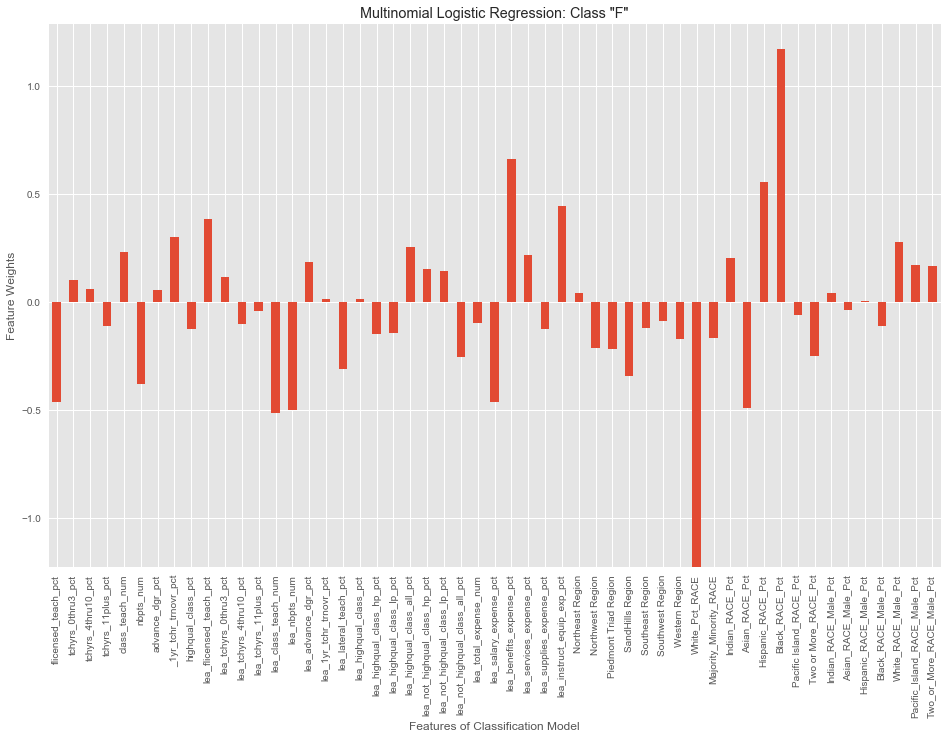

In [244]:
#plot feature weights for multinomial logistic regression model
plt.style.use('ggplot')

plt.figure(figsize=(16,10))

features = pd.Series(logmodel.coef_[0],index=df_names.columns)
features.plot(kind='bar')

#features = pd.Series(logmodel.coef_[0],index=df_names.columns)
#features.iplot(kind='bar',  xTitle='Features of Classification Model',
#                            yTitle='Feature Weights',
#                            title='Multinomial Logistic Regression: Class "F"',
#                            margin=dict(r=50,t=75,b=250,l=50),dimensions=(1000,1100))

#plot_data = go.Data([
#                    go.Bar(
#                    y = logmodel.coef_[0],
#                    x = df_names.columns,
#                    orientation = 'v')])

#layout = go.Layout(
#                height='100',
#                margin=go.Margin(b=300),
#                title='Multinomial Logistic Regression: Class "F"',
#                xaxis=dict(
#                title='Features of Classification Model'),
#                yaxis=dict(
#                title='Feature Weights'))

#fig = go.Figure(data=plot_data,layout=layout)
#py.iplot(fig)


plt.xlabel('Features of Classification Model')
plt.ylabel('Feature Weights')
plt.title('Multinomial Logistic Regression: Class "F"')
plt.show()

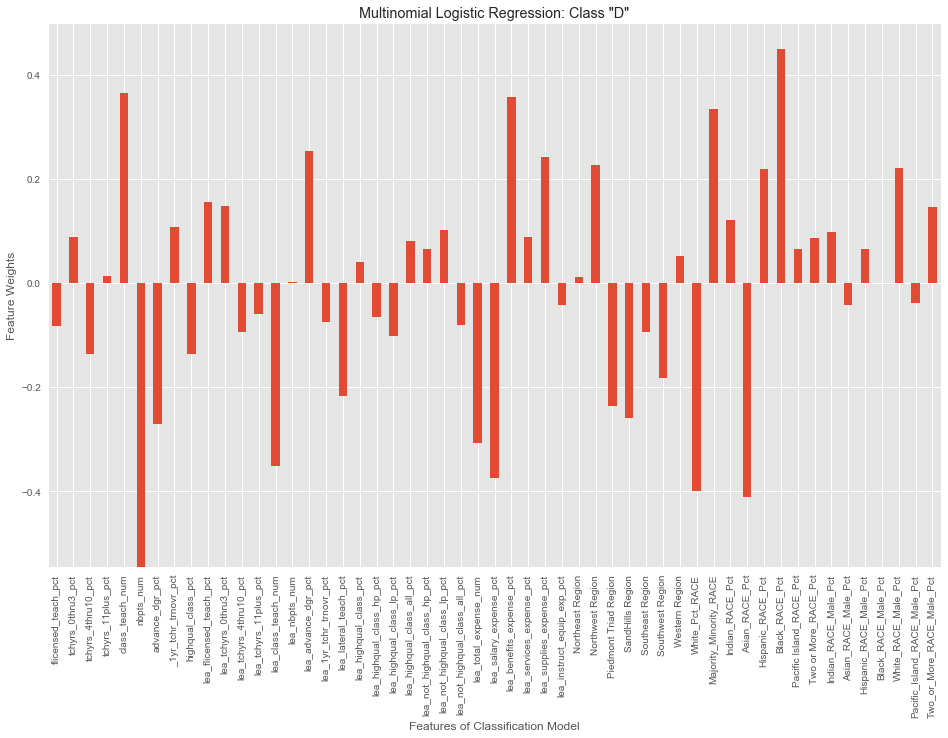

In [245]:
plt.style.use('ggplot')

plt.figure(figsize=(16,10))

features = pd.Series(logmodel.coef_[1],index=df_names.columns)
features.plot(kind='bar')

#features = pd.Series(logmodel.coef_[1],index=df_names.columns)
#features.iplot(kind='bar',  xTitle='Features of Classification Model',
#                            yTitle='Feature Weights',
#                            title='Multinomial Logistic Regression: Class "D"',
#                            margin=dict(r=50,t=75,b=250,l=50),dimensions=(1000,1100))


plt.xlabel('Features of Classification Model')
plt.ylabel('Feature Weights')
plt.title('Multinomial Logistic Regression: Class "D"')
plt.show()

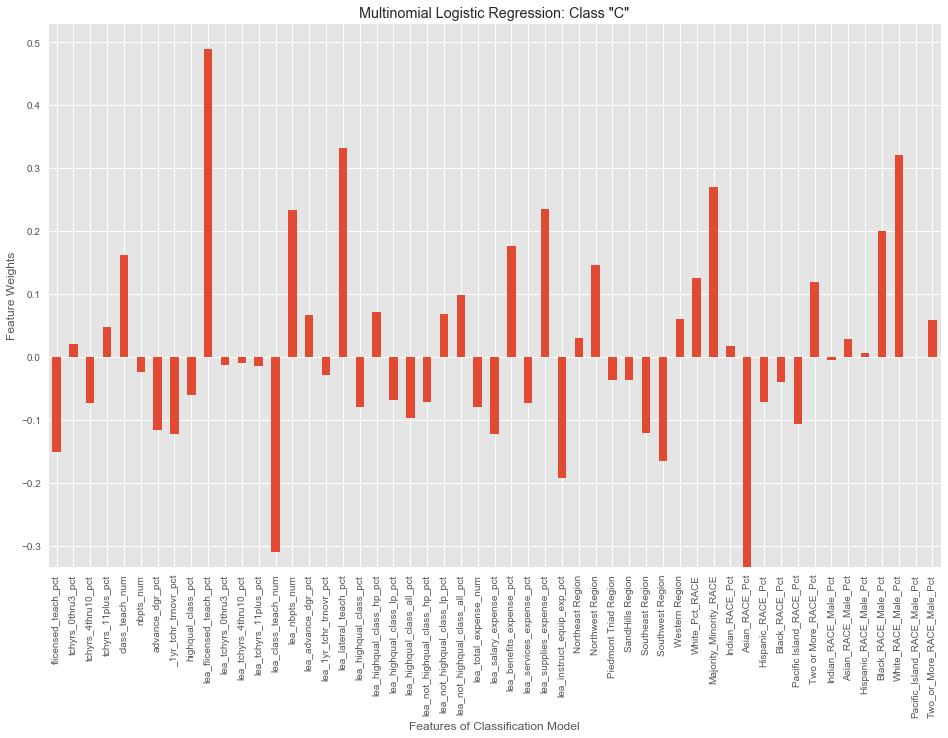

In [246]:
plt.style.use('ggplot')

plt.figure(figsize=(16,10))

features = pd.Series(logmodel.coef_[2],index=df_names.columns)
features.plot(kind='bar')

#features = pd.Series(logmodel.coef_[2],index=df_names.columns)
#features.iplot(kind='bar',  xTitle='Features of Classification Model',
#                            yTitle='Feature Weights',
#                            title='Multinomial Logistic Regression: Class "C"',
#                            margin=dict(r=50,t=75,b=250,l=50),dimensions=(1000,1100))


plt.xlabel('Features of Classification Model')
plt.ylabel('Feature Weights')
plt.title('Multinomial Logistic Regression: Class "C"')
plt.show()

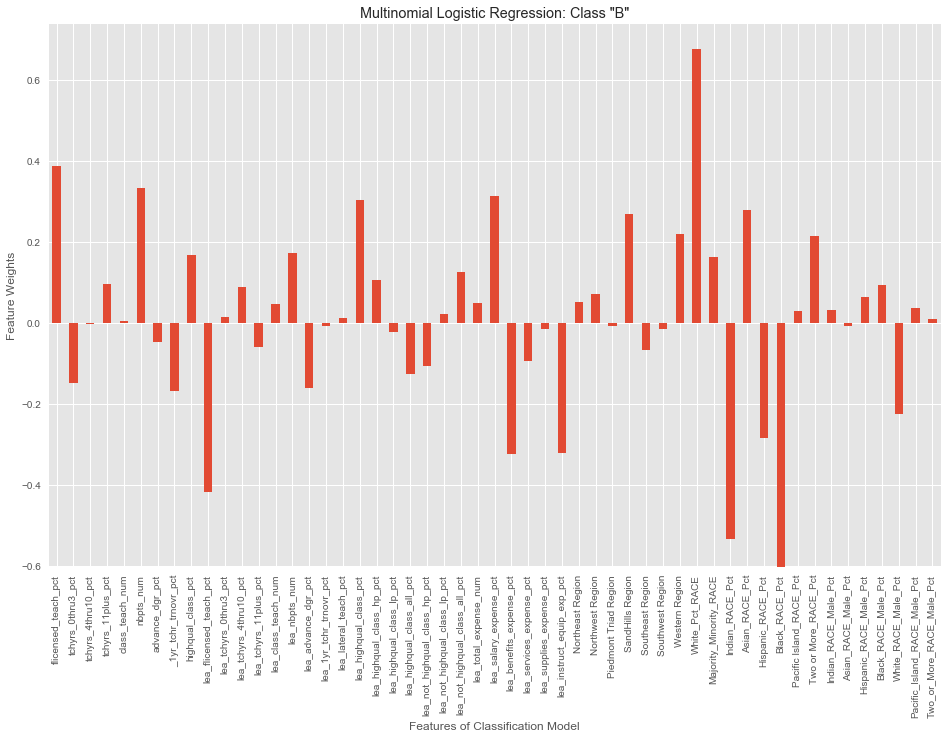

In [247]:
plt.style.use('ggplot')

plt.figure(figsize=(16,10))

features = pd.Series(logmodel.coef_[3],index=df_names.columns)
features.plot(kind='bar')

#features = pd.Series(logmodel.coef_[3],index=df_names.columns)
#features.iplot(kind='bar',  xTitle='Features of Classification Model',
#                            yTitle='Feature Weights',
#                            title='Multinomial Logistic Regression: Class "B"',
#                            margin=dict(r=50,t=75,b=250,l=50),dimensions=(1000,1100))

plt.xlabel('Features of Classification Model')
plt.ylabel('Feature Weights')
plt.title('Multinomial Logistic Regression: Class "B"')
plt.show()

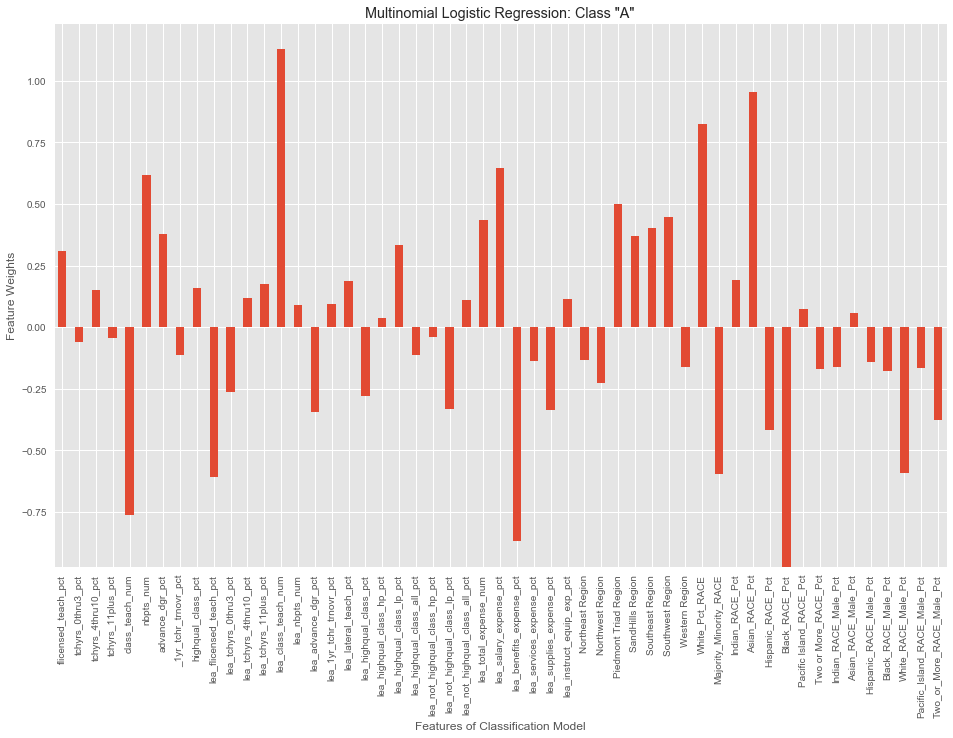

In [248]:
plt.style.use('ggplot')

plt.figure(figsize=(16,10))

features = pd.Series(logmodel.coef_[4],index=df_names.columns)
features.plot(kind='bar')

#features = pd.Series(logmodel.coef_[4],index=df_names.columns)
#features.iplot(kind='bar',  xTitle='Features of Classification Model',
#                            yTitle='Feature Weights',
#                            title='Multinomial Logistic Regression: Class "A"',
#                            margin=dict(r=50,t=75,b=250,l=50),dimensions=(1000,1100))

plt.xlabel('Features of Classification Model')
plt.ylabel('Feature Weights')
plt.title('Multinomial Logistic Regression: Class "A"')
plt.show()

In [249]:
#Support Vector Machine Classifier

In [250]:
#SVM classifier hyperparameters identified using Grid Search Cross-Validation
from sklearn.grid_search import GridSearchCV

param_grid = {'C':[0.01,0.1,1,10,100],'gamma':[10,1,0.1,0.01,0.001]}

from sklearn.svm import SVR, SVC
grid = GridSearchCV(SVC(random_state=2323),param_grid,verbose=3)

#fit using training data and best hyperparameters
grid.fit(X_train,y_train)

#check most performant hyperparameters
grid.best_params_

#return best estimator signature
grid.best_estimator_

#return best score w/ best hyperparameters
grid.best_score_

#generate predictions using test set predictors
grid_predictions = grid.predict(X_test)

#generate confusion matrix and classification report using true test set values and predictions
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.01, gamma=10 ................................................
[CV] ....................... C=0.01, gamma=10, score=0.484520 -   0.4s
[CV] C=0.01, gamma=10 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ....................... C=0.01, gamma=10, score=0.484520 -   0.4s
[CV] C=0.01, gamma=10 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] ....................... C=0.01, gamma=10, score=0.486781 -   0.4s
[CV] C=0.01, gamma=1 .................................................
[CV] ........................ C=0.01, gamma=1, score=0.484520 -   0.2s
[CV] C=0.01, gamma=1 .................................................
[CV] ........................ C=0.01, gamma=1, score=0.484520 -   0.2s
[CV] C=0.01, gamma=1 .................................................
[CV] ........................ C=0.01, gamma=1, score=0.486781 -   0.2s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ...................... C=0.01, gamma=0.1, score=0.484520 -   0.2s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ...................... C=0.01, gamma=0.1, score=0.484520 -   0.2s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ...................... C=0.01, gamma=0.1, score=0.486781 -   0.2s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   22.7s finished


[[  7  12   2   0   0]
 [  5  51  41   3   0]
 [  2  10 189  29   0]
 [  0   5  38  53   8]
 [  0   0   2  12  15]]


             precision    recall  f1-score   support

          0       0.50      0.33      0.40        21
          1       0.65      0.51      0.57       100
          2       0.69      0.82      0.75       230
          3       0.55      0.51      0.53       104
          4       0.65      0.52      0.58        29

avg / total       0.64      0.65      0.64       484



In [251]:
#from sklearn.feature_extraction.text import CountVectorizer

#X = logsvm_df.drop('SPG Score_GRADE',axis=1)
#X = X.drop('SPG Score Scaled',axis=1)

#cv = CountVectorizer()
#cv.fit(X)
#print(len(cv.vocabulary_))
#print('\n')
#print(cv.get_feature_names())

In [252]:
#Preparing for KDE plot comparisons of support vectors and original data

#reassign variable names
X = logsvm_df.drop('SPG Score_GRADE',axis=1)
X = X.drop('SPG Score Scaled',axis=1)
y = logsvm_df['SPG Score_GRADE']

#data frame of training feature data indexed during train/test split
X_tested_on = X.iloc[indices_train]

#further indexing to generate dataframe of support vectors identified by best estimator
df_support = X_tested_on.iloc[grid.best_estimator_.support_,:]

#support vector indexing of target variable, appended as new column to support vector data frame
df_support['SPG Score_GRADE'] = y[grid.best_estimator_.support_]

#reappend target to feature data, used for grouping in comparative visualization below
X['SPG Score_GRADE'] = y

#df_support.info()

C:\Users\jkras\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Users\jkras\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



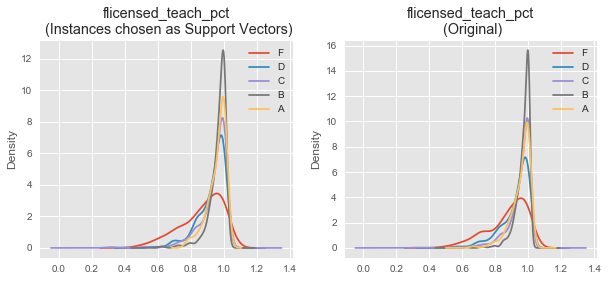

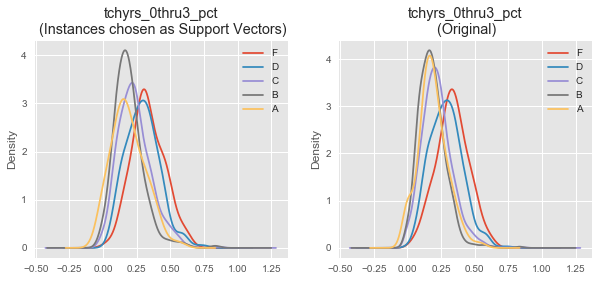

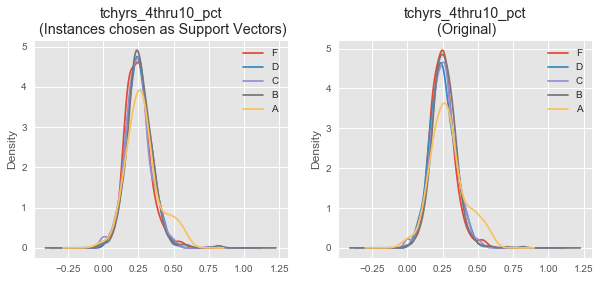

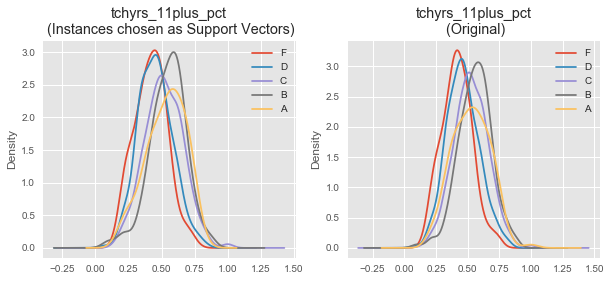

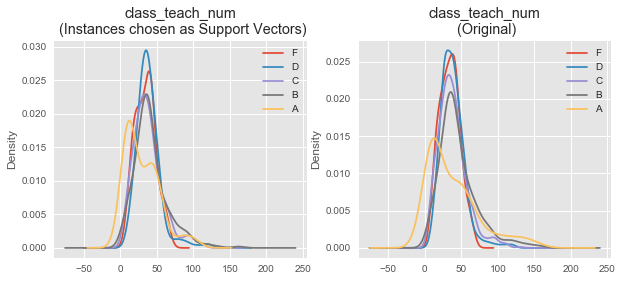

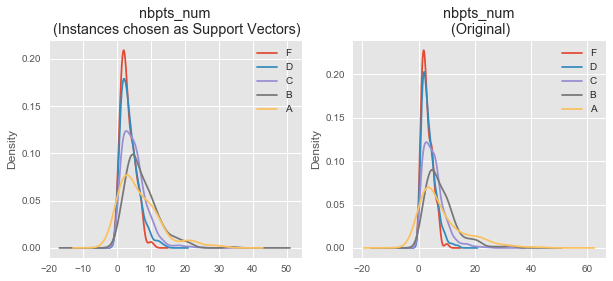

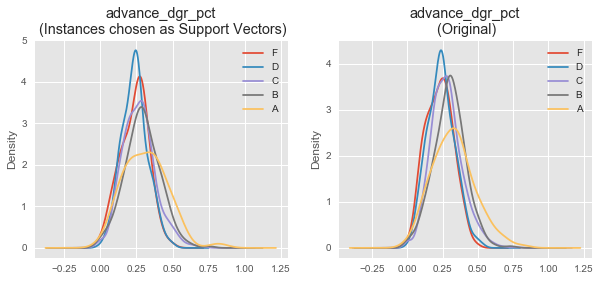

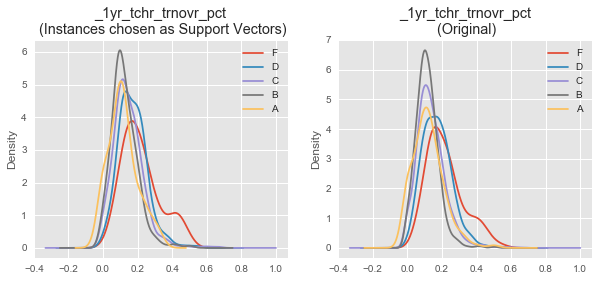

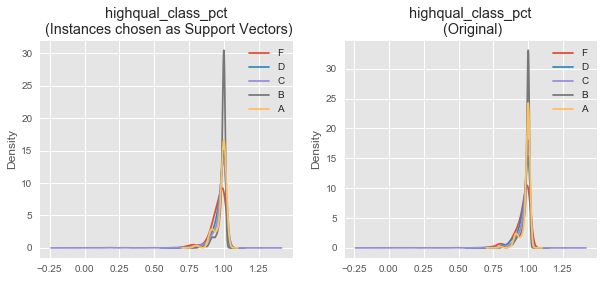

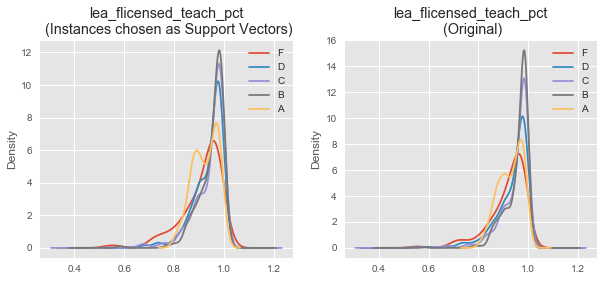

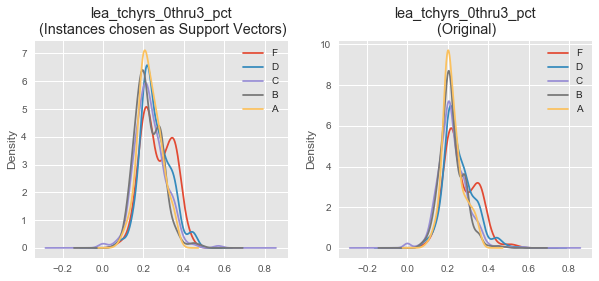

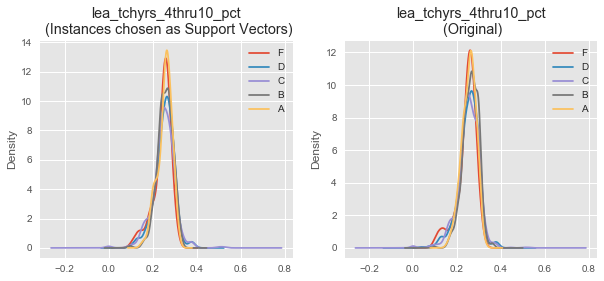

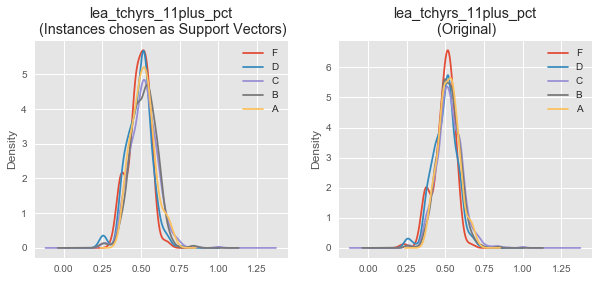

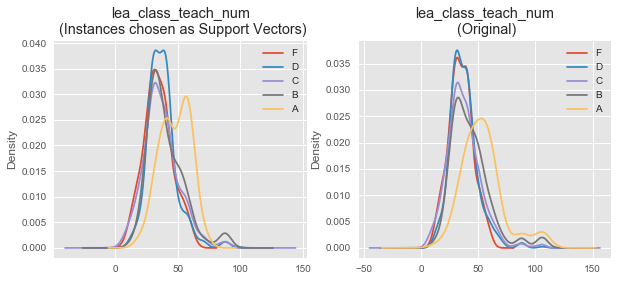

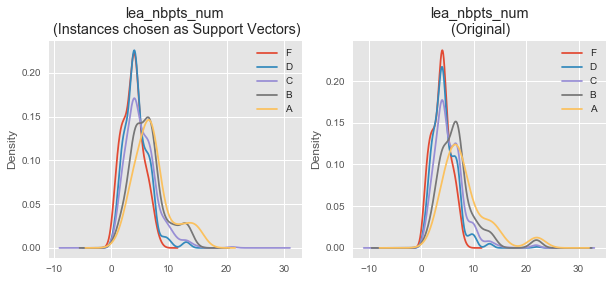

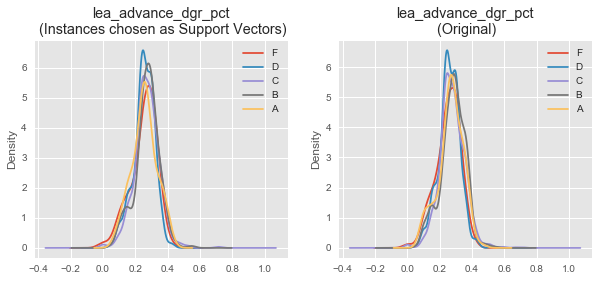

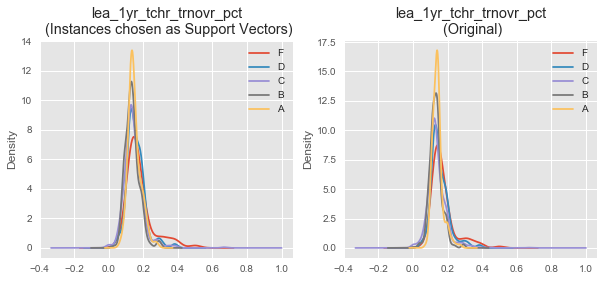

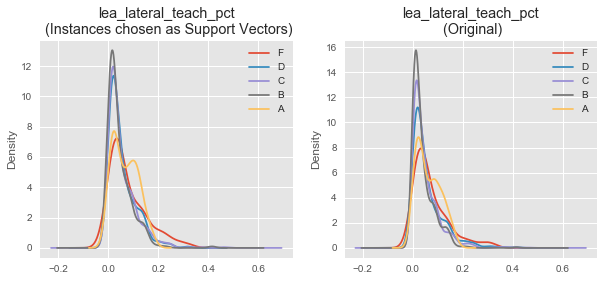

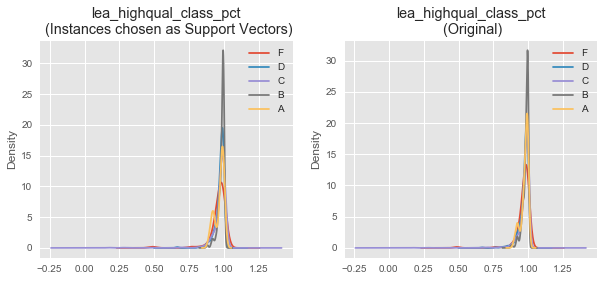

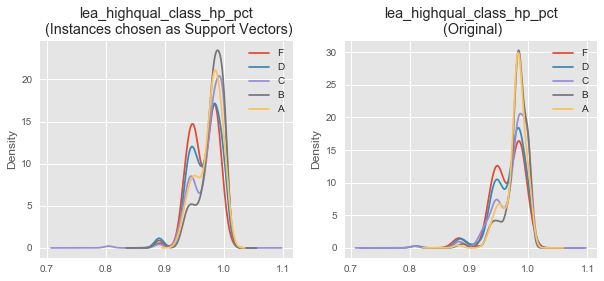

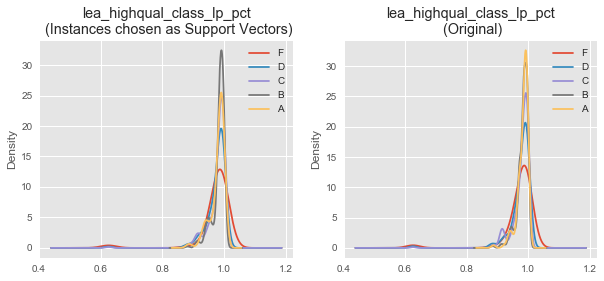

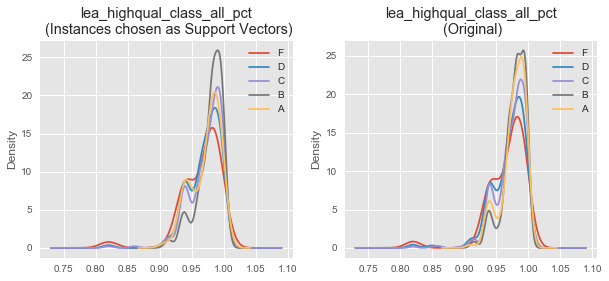

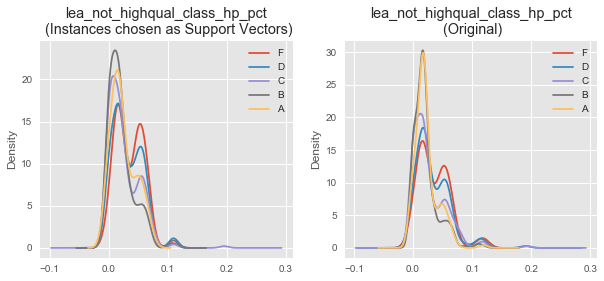

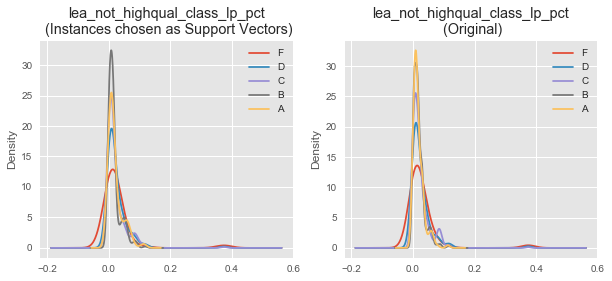

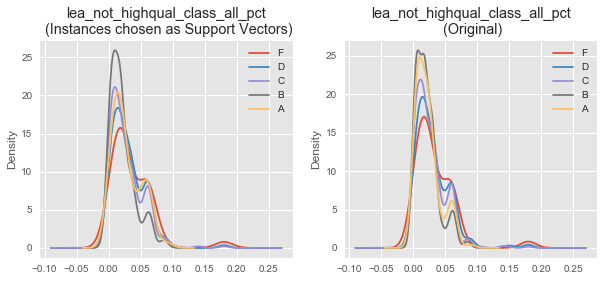

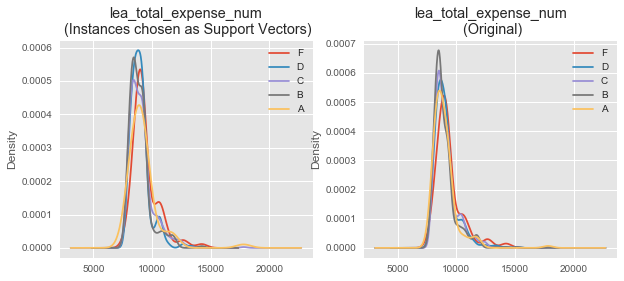

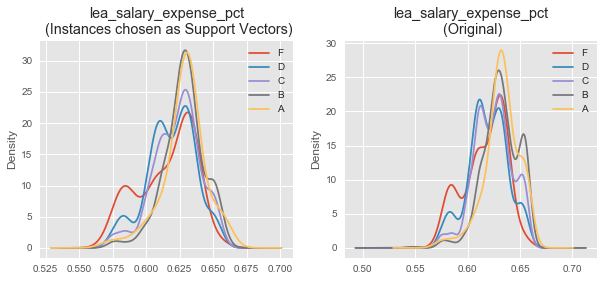

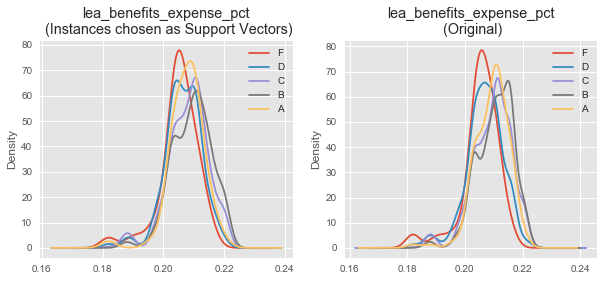

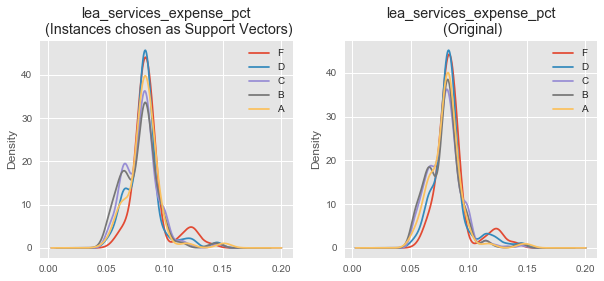

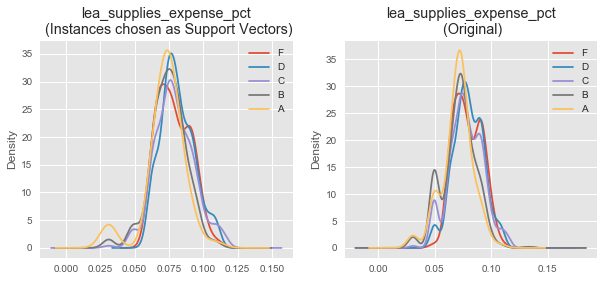

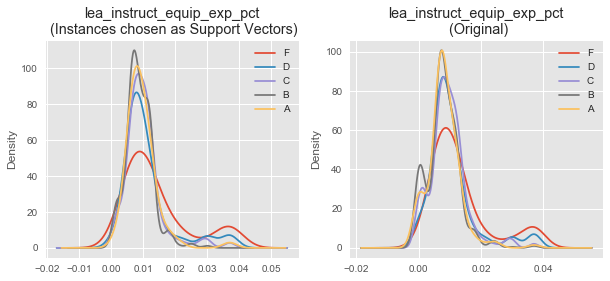

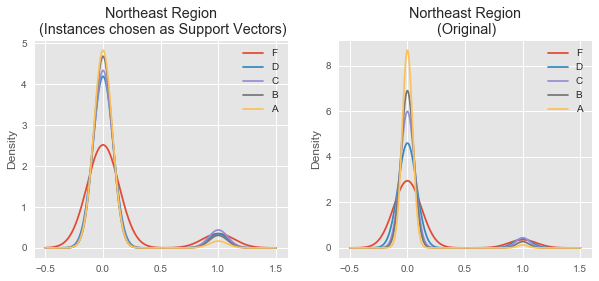

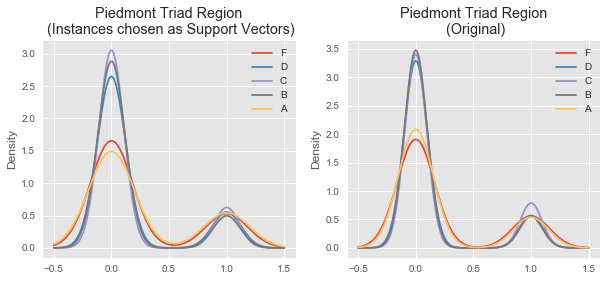

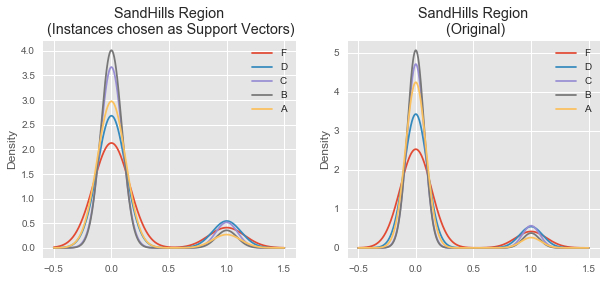

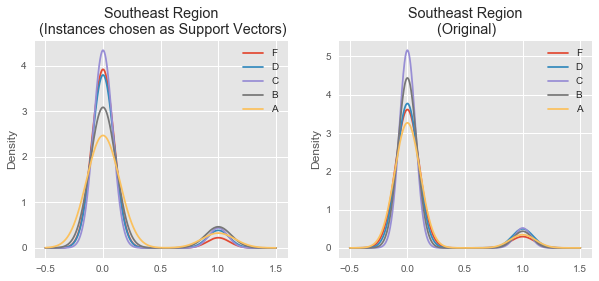

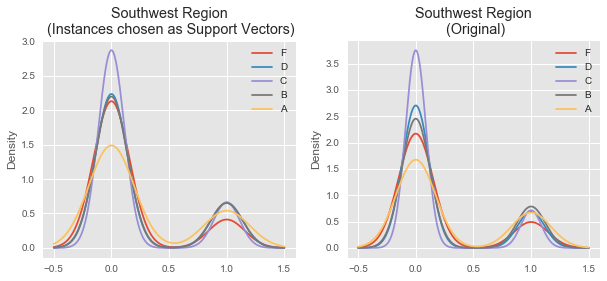

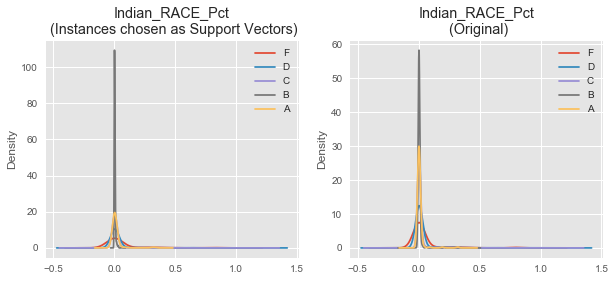

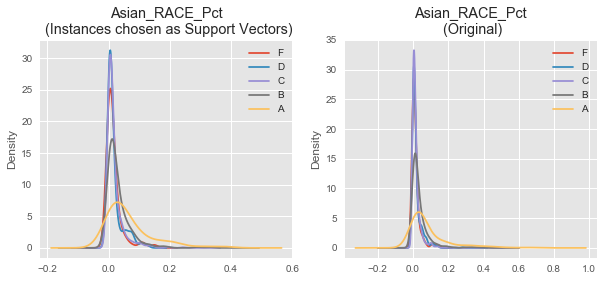

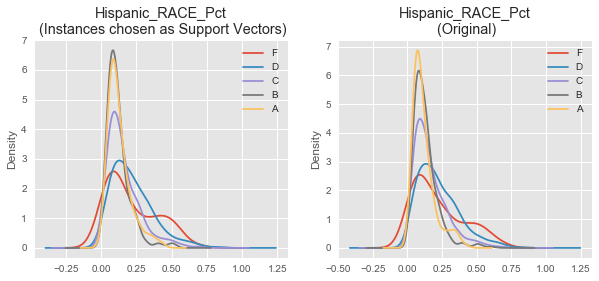

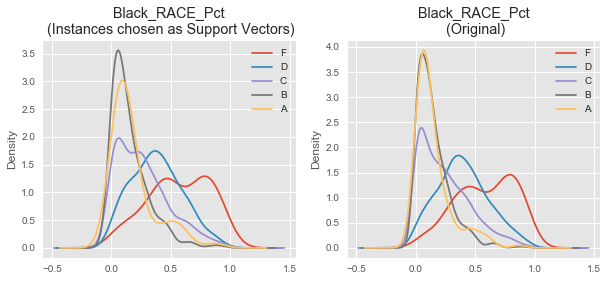

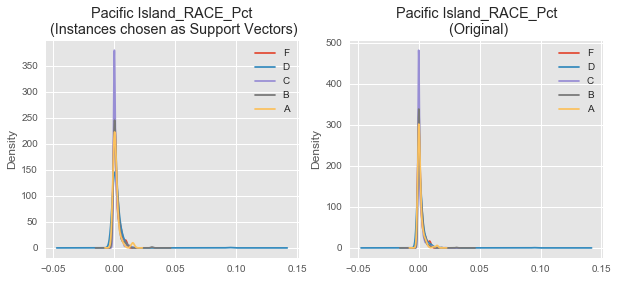

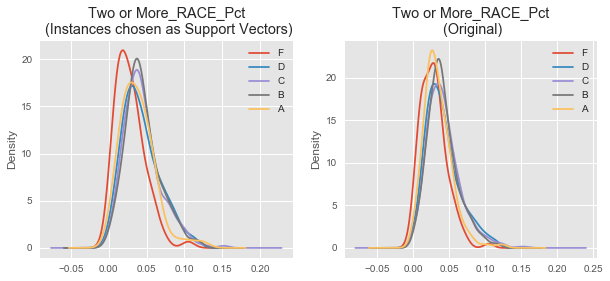

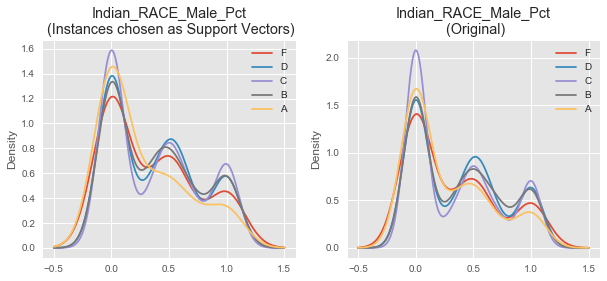

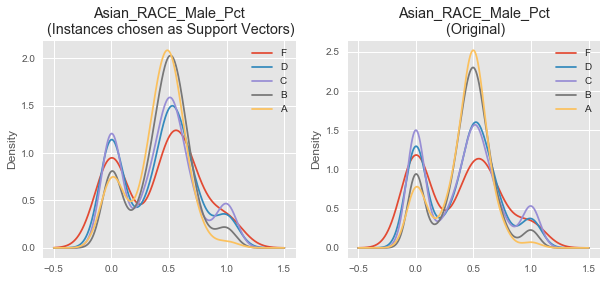

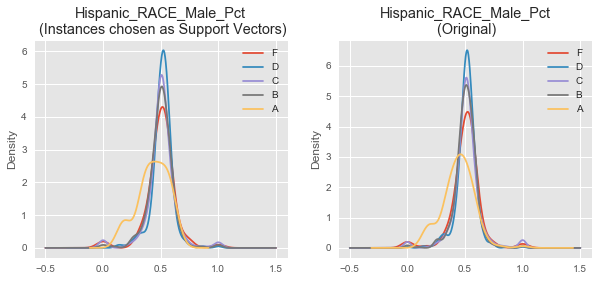

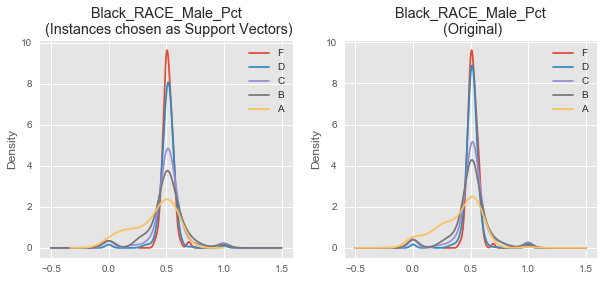

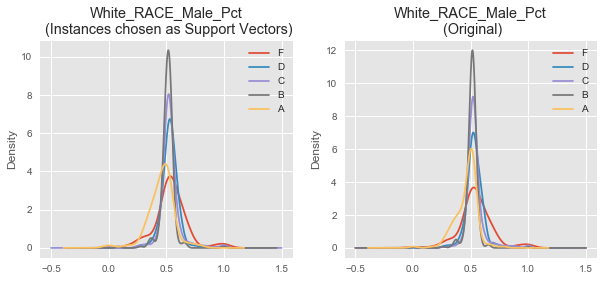

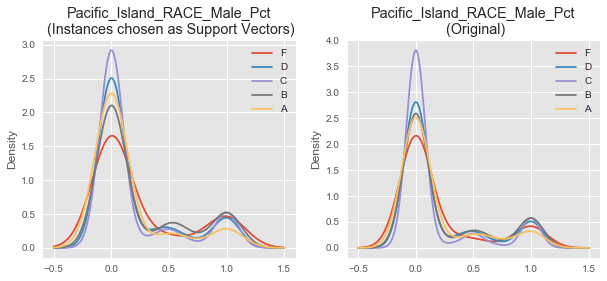

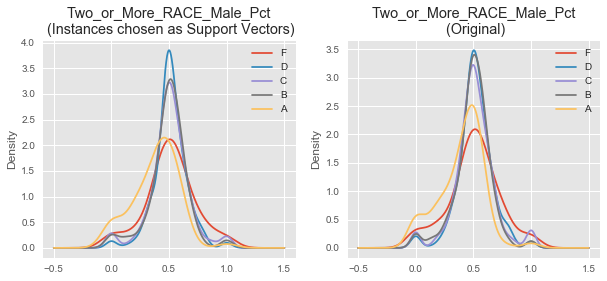

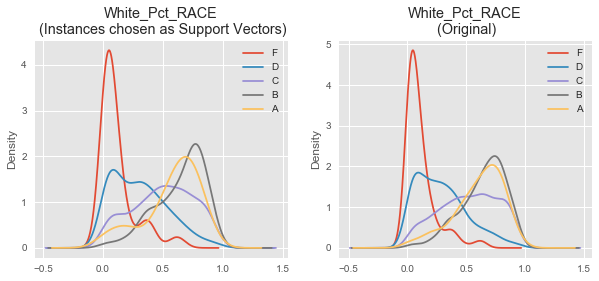

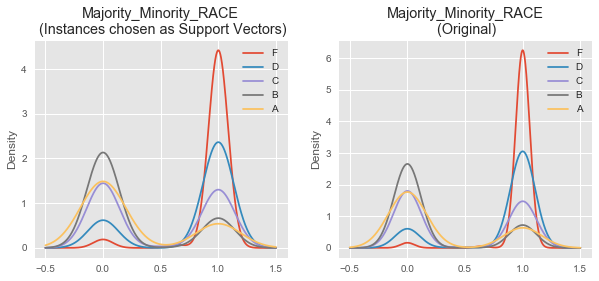

In [254]:
#import for KDE plots
from pandas.tools.plotting import boxplot

#grouping support vector dataframe and original data by the target variable
df_grouped_support = df_support.groupby(['SPG Score_GRADE'])
df_grouped = X.groupby(['SPG Score_GRADE'])


#vars_to_plot = list(df_names.columns)
#NB: Northwest Region and Western Region throw 'LinAlgError: singular matrix' errors!

vars_to_plot = ['flicensed_teach_pct', 'tchyrs_0thru3_pct', 'tchyrs_4thru10_pct',
       'tchyrs_11plus_pct', 'class_teach_num', 'nbpts_num', 'advance_dgr_pct',
       '_1yr_tchr_trnovr_pct', 'highqual_class_pct', 'lea_flicensed_teach_pct',
       'lea_tchyrs_0thru3_pct', 'lea_tchyrs_4thru10_pct',
       'lea_tchyrs_11plus_pct', 'lea_class_teach_num', 'lea_nbpts_num',
       'lea_advance_dgr_pct', 'lea_1yr_tchr_trnovr_pct',
       'lea_lateral_teach_pct', 'lea_highqual_class_pct',
       'lea_highqual_class_hp_pct', 'lea_highqual_class_lp_pct',
       'lea_highqual_class_all_pct', 'lea_not_highqual_class_hp_pct',
       'lea_not_highqual_class_lp_pct', 'lea_not_highqual_class_all_pct',
       'lea_total_expense_num', 'lea_salary_expense_pct',
       'lea_benefits_expense_pct', 'lea_services_expense_pct',
       'lea_supplies_expense_pct', 'lea_instruct_equip_exp_pct',
       'Northeast Region', 'Piedmont Triad Region',
       'SandHills Region', 'Southeast Region', 'Southwest Region',
        'Indian_RACE_Pct','Asian_RACE_Pct','Hispanic_RACE_Pct',
        'Black_RACE_Pct','Pacific Island_RACE_Pct','Two or More_RACE_Pct',
        'Indian_RACE_Male_Pct','Asian_RACE_Male_Pct','Hispanic_RACE_Male_Pct',
        'Black_RACE_Male_Pct','White_RACE_Male_Pct','Pacific_Island_RACE_Male_Pct',
        'Two_or_More_RACE_Male_Pct', 'White_Pct_RACE', 'Majority_Minority_RACE']

#comparative KDE plots of all features
for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['F','D','C','B','A'])
    plt.title(v+'\n (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['F','D','C','B','A'])
    plt.title(v+'\n (Original)')